##### To develop a hybrid anomaly detection model using a sparse autoencoder, Isolation Forest, and XGBoost in sequence, begin by loading and cleaning your data. Select important features and split the dataset into training and testing sets. Normalize these features through feature scaling. Use a sparse autoencoder to reduce the dimensionality of your data, enhancing manageability and focus. Apply an Isolation Forest to effectively identify initial anomalies, and then refine the detection with XGBoost, a powerful classifier that improves the model's sensitivity and accuracy. Evaluate the model's performance using precision, recall, F1-score, and a confusion matrix. This approach combines the strengths of dimensionality reduction, anomaly isolation, and advanced classification to effectively detect anomalies in diverse data scenarios.

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

Epoch 1/50
191/191 [==============================] - 0s 980us/step - loss: 495.1997
Epoch 2/50
191/191 [==============================] - 0s 1ms/step - loss: 490.7129
Epoch 3/50
191/191 [==============================] - 0s 1ms/step - loss: 490.6911
Epoch 4/50
191/191 [==============================] - 0s 990us/step - loss: 490.6835
Epoch 5/50
191/191 [==============================] - 0s 1ms/step - loss: 490.6772
Epoch 6/50
191/191 [==============================] - 0s 975us/step - loss: 490.6727
Epoch 7/50
191/191 [==============================] - 0s 1ms/step - loss: 490.6694
Epoch 8/50
191/191 [==============================] - 0s 1ms/step - loss: 490.6669
Epoch 9/50
191/191 [==============================] - 0s 1ms/step - loss: 490.6654
Epoch 10/50
191/191 [==============================] - 0s 973us/step - loss: 490.6636
Epoch 11/50
191/191 [==============================] - 0s 956us/step - loss: 490.6627
Epoch 12/50
191/191 [==============================] - 0s 1ms/step - loss: 

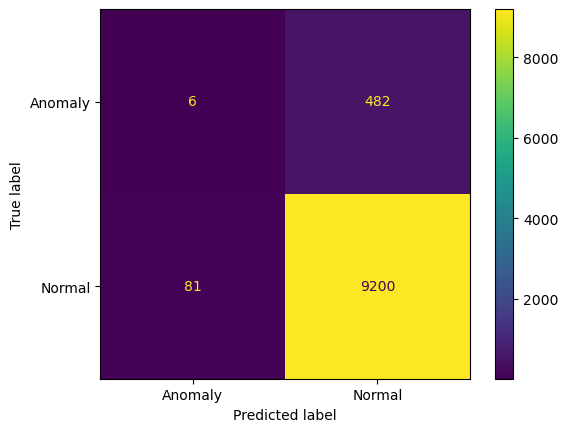

In [10]:

def hybrid_anomaly_detection():
    # Load and preprocess the dataset
    # Load data from a CSV file   
    data = pd.read_csv('adultdata.csv')
    
    #convert all the values in the columns into numeric
    label_encoder = LabelEncoder()
    for column in data.select_dtypes(include=['object']).columns:
        data[column] = label_encoder.fit_transform(data[column])
    
    data = data.drop('Sex', axis=1)
    
    X = data.drop('fnlwgt', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['fnlwgt']
    
    y = np.where(y_cont > 40000, 1, 0)  # Define `threshold` based on your domain knowledge
    
    # Select top k features; k might be adjusted based on the dataset
    selector = SelectKBest(f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    #data.info()

    data.dropna(axis=0, inplace=True)
    
    
    
    
    # Dimensionality reduction with sparse autoencoder
    input_dim = X_selected.shape[1]
    encoding_dim = 32
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_selected, X_selected, epochs=50, batch_size=256, shuffle=True)
    
    encoder = Model(input_layer, encoded)
    X_encoded = encoder.predict(X_selected)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Use XGBoost to classify data points as normal or anomaly
    xgb = XGBClassifier()
    xgb.fit(X_train_scaled, y_train)
    xgb_preds = xgb.predict(X_train_scaled)
    
    
    # Filter only rows SVM detected as normal
    normal_indices_train = xgb_preds == 1
    X_train_normal = X_train_scaled[normal_indices_train]
    
    # Train Isolation Forest on the filtered normal data
    iso_forest = IsolationForest(contamination=.01, random_state=42)
    iso_forest.fit(X_train_normal)
    
    # Predict on the test data with Isolation Forest
    if_predictions = iso_forest.predict(X_test)
    if_predictions = np.where(if_predictions == 1, 1, 0)  # Convert -1, 1 to 0, 1
    
    # Evaluate the model
    precision = precision_score(y_test, if_predictions, pos_label=0)
    recall = recall_score(y_test, if_predictions, pos_label=0)
    f1 = f1_score(y_test, if_predictions, pos_label=0)
    
    print(classification_report(y_test, if_predictions))
    

    # Print metrics
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Display the confusion matrix
    cm = confusion_matrix(y_test, if_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()


hybrid_anomaly_detection()

